# **Simulating F1-ATPase Rotation Dynamics**
<hr>

## **Introduction**

Contained within this notebook is the complete implementation of **Langevin dynamics using stochastic methods**. <br>
F1-ATPase has the ability to convert chemical energy into mechanical energy. Due to this, F1-ATPase has important implications <br>
for fields such as biomechanical engineering. <br>

This notebook will successfully do the following:<br>
1) **Simulate rotational dynamics of F1-ATPase alongside stochastic restrains**.
2) **Prove generating sufficient and meaningful data for AI models is possible**.

<br>
<hr>

## **Theory**
The simulation models the F1-ATPase motor using a hybrid Langevin Gillespie approach. 

1) Gillespie Algorithm: Determines the motor's current chemical state
2) Langevin Dynamics: Pulls the beads current angle toward an equilibrium point, defined by the current state

### **1. State Transitions (Gillespie)**


The Gillespie algorithm helps model the motors jump between chemical states. In order to achieve this, at every time step ($\Delta t$), it will determine if a transition occurs. If a transition occurs it will determine what new state the system belongs to.

The process provides the necessary information in order to calculate the new target angle:
* The `transition_matrix` stores the probabilities of these jump, from one state to another
* The algorithm uses these rates to determine if a state change occurs each step ($\Delta t$)
* Through this method two variables are returned
  * A `cycle_count` variable tracks full rotations (forward and backward) in order to ensure the angle updates properly
  * A `new_state` variable tracks the current state of the system
* Using these variables allows us to finally update our angle toward the current equilibrium point 


$$
\theta_{\rm target} = \theta_{\rm state} + \text{cycle\_count} \cdot \frac{2\pi}{3}
$$

##### **Corresponding Code**
```C++
   double LangevinGillespie::update_theta(int state, int cycle_count) const {              
       return theta_states->at(state) + static_cast<double>(cycle_count) * 2.0             
                                      * std::numbers::pi / 3.0;                           
   }                                                                                       


```

### **2. Angle Updates (Langevin)**

Once the Gillespie step determines our new target angle ($\theta_{\rm target}$), Langevin dynamics can simulate the continuous physical rotation of the bead being pulled toward the equilibrium point.

The bead acts as if it is in a well, trying to reach the equilibrium point. Despite its efforts, external factors such as thermal energy ($\text{k}_{\rm B} T$) cause random fluctuations that kick the bead around. From this summary the simulation will have to account for two forces:
* **Drift (Deterministic)**: Acts similar to a spring, in the sense that the force pulls the beads current angle ($\theta$) toward the target angle ($\theta_{\rm target}$). Its strength is determined by the elastic constant $\kappa$
* **Diffusion (Stochastic)**: Represents those random "kicks" from thermal noise (Brownian motion), in which relates to thermal energy ($\kappa_{\rm B} T$)

Although three angle update methods are implemented (Heun, Euler-Maruyama, and Probabilistic), Heun will be chosen for its exceptional accuracy. 

$$
\theta(t+\Delta t) = \theta(t)
+ \frac{\Delta t}{2} \left( \text{drift}_{\rm term} + \text{drift}_{\rm predict} \right)
+ \sqrt{\Delta t} \, \text{diffusion}_{\rm term} \, \eta
$$

##### **Corresponding Code**
```C++
    double LangevinGillespie::heun_1d(                                                     
        double current_angle,                                                              
        double theta_target,                                                               
        std::mt19937& local_rng                                                            
        ) const {                                                                          
        double drift_term = drift(current_angle, theta_target);                            
        double diffusion_term = diffusion();                                               
        double eta = normal_dist(local_rng);                                               
                                                                                           
        // Predictor step                                                                  
        double sqrt_dt = std::sqrt(dt.value());                                            
        double y_predict = current_angle + dt.value() * drift_term + sqrt_dt               
        * diffusion_term * eta;                                                            
                                                                                           
        // Corrector step                                                                  
        double drift_predict = drift(y_predict, theta_target);                             
        return current_angle + (dt.value() / 2.0) * (drift_term + drift_predict)           
                             + sqrt_dt * diffusion_term * eta;                             
   }                                                                                       
```
<hr>


## **Design Decisions: Why C++ / CUDA?**
Before we dive into implementation lets consider our second goal of this project: prove generating sufficient and meaningful data for an AI model is possible. <br>
Generating a large dataset for AI models requires thousands to millions of data points. This means we will have to run this simulation multiple times.

### **The Problem: Python is too slow!**
The first implementation of this project started within Python. This was wonderful for prototyping and validating physics, but it was far too slow for data generation.

Some primary bottlenecks within Python include its Global Interpreter Lock (GIL), which prevents true parallelism, alongside being an interpreted language. These issues made scaling simulations efficiently unreachable, as shown with the legacy benchmark. (Results below)

### **The Solution: C++, Cuda, and Pybind11**
We are able to take full advantage of Python's ecosystem while also achieving blazingly fast speeds, this is why I used Pybind11.

Pybind11 allows us to write Python Code, while directly accessing C++/CUDA code. The code has also been rewritten to support massive amounts of parallelization, and bypassing the GIL. 

### **The Results: A 561 times speed up**
The results of this optimization are absolutely incredible. The chart below compares the time taken to run 100,000 simulations (2000 steps each) using different implementations.
The original "Legacy" (Python) code took around 16.68 minutes (1000.89s) to complete. The final CUDA version finished the same job within 1.78 seconds. 

This is a **560.90 times** increase in computation speed. This makes our goal of generating AI datasets not only possible, but trivial.  

![Time Comparison for 100 Thousand simulations, with 2000 steps](analysis/results/time_comparison_100k.png)

<hr>

## **Simulation Setup**

Since I have established the what (Theory) and why (Performance), I can finally show you the how. Before running any simulations we must first import our libraries and parameters.

### **Imports**
First lets import all needed libraries, in which includes our `f1sim` module, and `compute_transition_matrix` helper

In [ ]:
from bin.f1sim import LangevinGillespie
from src.utils.compute_transition_matrix import compute_transition_matrix

# -=-=-=-=-=-=-=-=-= Helper Imports -=-=-=-=-=-=-=-=-=
import numpy as np
import math


ModuleNotFoundError: No module named 'f1sim'

## Simulation configuration
Next, we will create an instance of our `LangevinGillespie` class and define our parameters

In [ ]:
# 1. Create our class instance
LG = LangevinGillespie()

# 2. Simulation Parameters
LG.steps = 2000
LG.dt = 1e-6
LG.method = "heun"

# 3. Mechanical / Thermal Setup 
LG.kappa = 56
LG.kBT = 4.14
LG.gammaB = LG.computeGammaB(a=20, r=19, eta=1e-9)

#  4. Multi State Setup 
LG.theta_states = np.array([3, 36, 72, 116]) * math.pi / 180  # Deg → Rad
LG.initial_state = 0 # Start at 3 degrees 

#  5. Transition rate matrix 
LG.transition_matrix = compute_transition_matrix(LG)


## **Data Generation**

Now that LG is fully configured, we can start generating data. I will show you three different simulation methods, along with their strengths
1. simulate(optional int: seed): Generates a single trajectory, no thread overhead meaning better times for very small datasets
2. simulate_multithreaded(unsigned int: nSim,unsigned int: numThreads, optional int: seed): Distributes the number of simulations on the CPU. Ideal for fast simulations without the use of a dedicated GPU. 
3. simulate_multithreaded_cuda(unsigned_int: nSim, optional int: seed): Runs all nSim simulations in parallel on the GPU. Blazingly fast, but requires the a Nvidia GPU

### **Running a single simulation**
First, lets run a single simulation, and save its trajectory for analysis

In [ ]:
import time

SEED_VAL = 0
last = time.time()
angles, states, thetas = LG.simulate(seed=SEED_VAL)
now = time.time()
print(f"Simulation complete in {now - last:.4f} seconds")

Simulation complete in 0.0003 seconds


### **Generating our Datasets**

We have two high performance parallel methods (`simulate_multithreaded` and `simulate_multithreaded_cuda`).

As a final demonstration, we will run a benchmark of 100,000 simulations. This will show the practical performance difference between the CPU and GPU. The resulting data will be used in the "Analysis" section

In [ ]:
N_SIMS = 100_000
CPU_THREAD_NUMBER = 32

# -=-=-=-=-=-=-=-=-= 1. CPU Multithreaded -=-=-=-=-=-=-=-=-=
print(f"Running {N_SIMS} simulations on {CPU_THREAD_NUMBER} CPU threads...")
start_time_cpu = time.time()

combined_bead_positions_cpu, combined_states_cpu, combined_target_thetas_cpu = (
    LG.simulate_multithreaded(N_SIMS, CPU_THREAD_NUMBER, seed=SEED_VAL)
)

end_time_cpu = time.time()
cpu_time = end_time_cpu - start_time_cpu
print(f"  CPU simulation complete in: {cpu_time:.4f} seconds")


# -=-=-=-=-=-=-=-=-= 2. GPU (CUDA) -=-=-=-=-=-=-=-=-=
print(f"\nRunning {N_SIMS} simulations on the GPU...")
start_time_gpu = time.time()

# Note: The CUDA function expects the argument 'base_seed'
combined_bead_positions_gpu, combined_states_gpu, combined_target_thetas_gpu = (
    LG.simulate_multithreaded_cuda(N_SIMS, seed=SEED_VAL)
)

end_time_gpu = time.time()
gpu_time = end_time_gpu - start_time_gpu
print(f"  GPU simulation complete in: {gpu_time:.4f} seconds")


# -=-=-=-=-=-=-=-=-= 3. Results -=-=-=-=-=-=-=-=-=
print(f"\n Speedup (GPU vs CPU): {cpu_time / gpu_time:.2f}x")

Running 100000 simulations on 32 CPU threads...
  CPU simulation complete in: 4.3860 seconds

Running 100000 simulations on the GPU...
  GPU simulation complete in: 0.7223 seconds

 Speedup (GPU vs CPU): 6.07x


<hr>

## **Analysis**

Now that the datasets are generated, lets analyze the results. We can start by visualizing the trajectory with `simulate()`

`Note`: Our simulation uses radians for its input and outputs, all graph data has been converted to degrees

### **Visualizing a Single Trajectory**
The plot below shows, that the model is indeed behaving as expected.
1. Top Plot: The **Bead Angle** is being pulled toward the **Target Angle**. You can see the random kicks caused by diffusion, as the angle fluctuates around the target.
2. Bottom Plot: The **State** shows each discrete jump, from the Gillespie algorithm.
3. Colored Background: The background color, represents the current state. This changes any time our state changes
   1. (Blue: State 0, Orange: State 1, Green, State 2, Red: State 3)

![Single Simulation Trajectory](analysis/results/single_simulation_results_seed0.png)

## **Single Trajectory PDF**


![Single Simulation PDF](analysis/results/single_simulation_pdf_seeded0.png)


<Figure size 640x480 with 0 Axes>

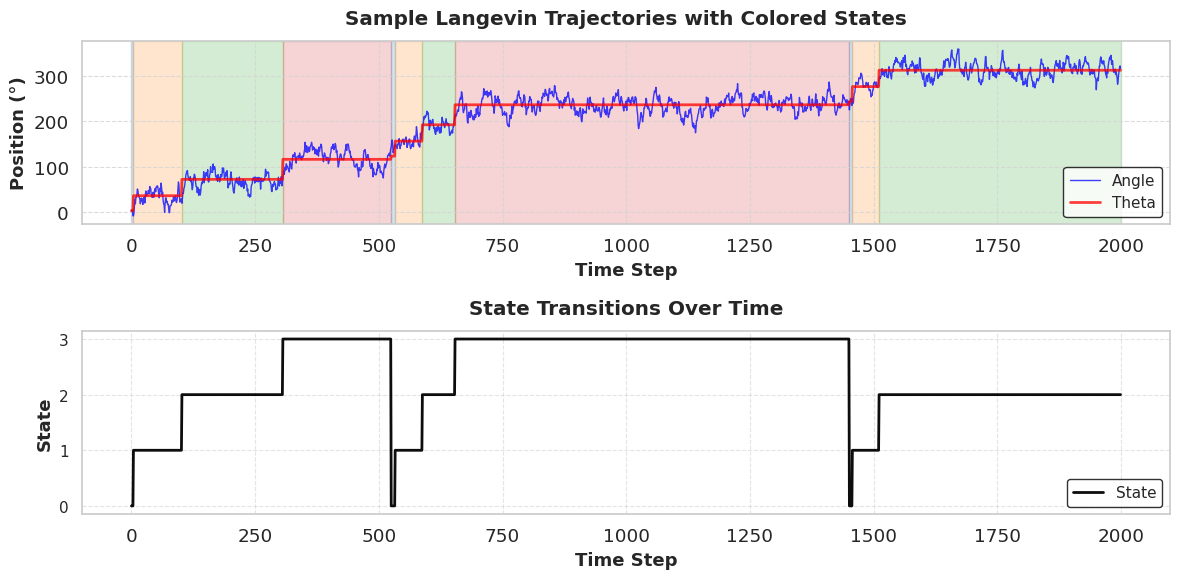

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

deg_factor = 180 / math.pi
for i in range(len(angles)):
    angles[i] *= deg_factor  # Convert to degrees
    thetas[i] *= deg_factor  # Convert to degrees

sns.set_theme(style="whitegrid", font_scale=1.2)
sns.despine(trim=True)

# Professional 4-color palette
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

plt.figure(figsize=(12, 6), dpi=100)

plt.subplot(2, 1, 1)

regionStart = 0
for step in range(1, len(thetas)):
    if thetas[regionStart] != thetas[step] or (step == len(thetas) - 1):
        plt.axvspan(
            regionStart,
            step,
            color=colors[states[regionStart] % len(colors)],
            alpha=0.20, 
            zorder=0
        )
        regionStart = step

# Plot trajectories
plt.plot(angles, color="#0000FF", alpha=0.75, linewidth=1.0, linestyle="-", label="Angle")
plt.plot(thetas, color="#FF0000", alpha=0.75, linewidth=2.0, linestyle="-", label="Theta")  

plt.grid(True, color="lightgrey", linestyle="--", linewidth=0.8, alpha=0.8)
plt.xlabel("Time Step", fontsize=13, weight="bold")
plt.ylabel("Position (°)", fontsize=13, weight="bold")
plt.title("Sample Langevin Trajectories with Colored States", pad=12, weight="bold")
plt.legend(loc="lower right", fontsize=11, frameon=True, edgecolor="black", facecolor="white")


# Bottom subplot: states
plt.subplot(2, 1, 2)
plt.plot(states, color="black", alpha=0.95, linewidth=2.0, linestyle="-", label="State")
plt.ylabel("State", fontsize=13, weight="bold")
plt.xlabel("Time Step", fontsize=13, weight="bold")
plt.title("State Transitions Over Time", pad=12, weight="bold")
plt.grid(True, color="lightgrey", linestyle="--", linewidth=0.8, alpha=0.6)
plt.yticks(np.arange(len(LG.theta_states)), fontsize=11)
plt.legend(loc="lower right", fontsize=11, frameon=True, edgecolor="black", facecolor="white")

plt.tight_layout(pad=1.0);

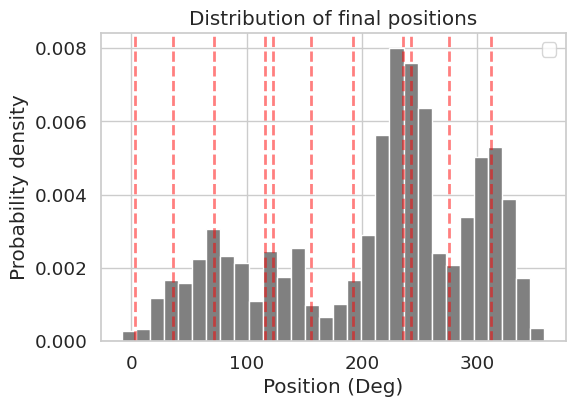

In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

deg_factor = 180 / math.pi

plt.figure(figsize=(6, 4))
plt.hist(angles, bins=30, color="grey", density=True)
plt.xlabel("Position (Deg)")
plt.ylabel("Probability density")
plt.title("Distribution of final positions")

# Sort equilibrium points
equilibrium_pts = set(thetas)
for eq in equilibrium_pts:
    plt.axvline(x=eq, color="red", linestyle="--", linewidth=2, alpha=0.5)

# TODO add label, then remove warning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.legend(loc="upper right", frameon=True)

<hr>

### Thread Support

In [ ]:
MAX_THREAD_COUNT = 32
SIMULATION_COUNT = 32

In [ ]:
# Threads are implemented in CPP in order to remove GIL restrictions
combined_bead_positions, combined_states, combined_target_thetas = (
    LG.simulate_multithreaded(SIMULATION_COUNT, MAX_THREAD_COUNT)
)

In [ ]:
combined_bead_positions = np.array(combined_bead_positions, dtype=np.float64)
combined_target_thetas = np.array(combined_target_thetas, dtype=float)
combined_states = np.array(combined_states, dtype=float)

combined_bead_positions *= deg_factor
combined_target_thetas *= deg_factor

# Turn the 2D matrix into a vector
combined_bead_positions = np.vstack([np.array(b) for b in combined_bead_positions]).T
combined_target_thetas = np.vstack([np.array(t) for t in combined_target_thetas]).T

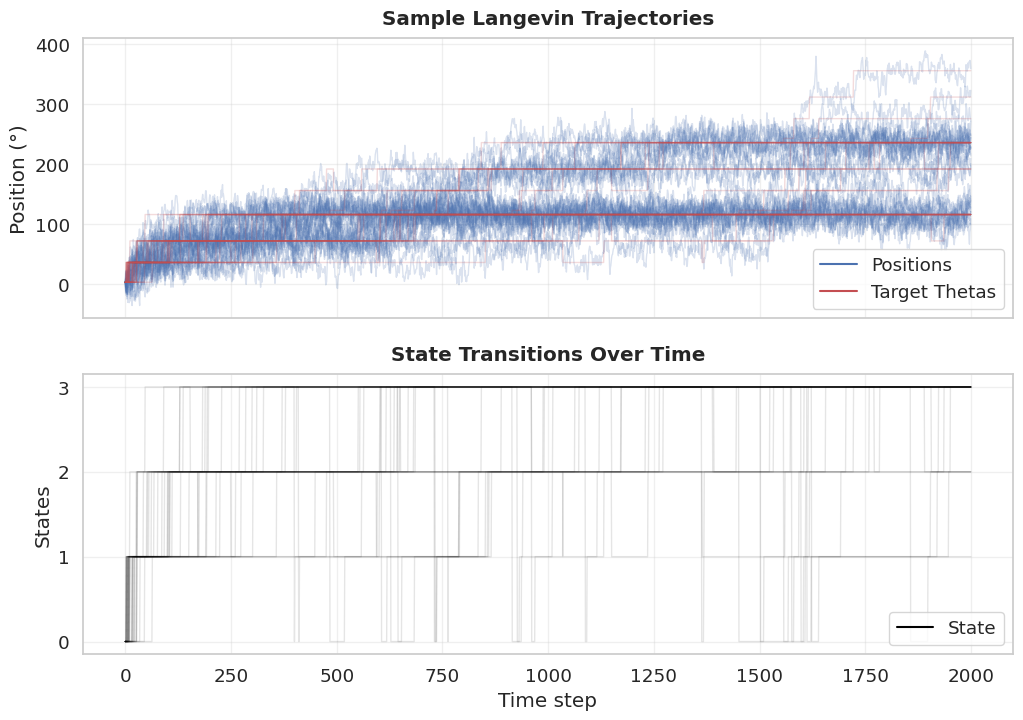

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(combined_bead_positions, color="b", alpha=0.2, linewidth=1)
axs[0].plot([], [], color="b", label="Positions")
axs[0].legend(loc="lower right", frameon=True)
axs[0].plot(np.array(combined_target_thetas), color="r", alpha=0.2, linewidth=1)

axs[0].plot([], [], color="r", label="Target Thetas")
axs[0].set_title("Sample Langevin Trajectories", pad=10, weight="bold")
axs[0].set_ylabel("Position (°)")
axs[0].grid(True, alpha=0.3)
axs[0].legend(loc="lower right", frameon=True)

for state_group in combined_states:
    axs[1].plot(np.array(state_group).T, color="black", alpha=0.1, linewidth=1)

axs[1].set_title("State Transitions Over Time", pad=10, weight="bold")
axs[1].set_xlabel("Time step")
axs[1].set_ylabel("States")
axs[1].grid(True, alpha=0.3)
axs[1].set_yticks(np.arange(len(LG.theta_states)))
axs[1].plot([], [], color="black", label="State")
axs[1].legend(loc="lower right", frameon=True);

<hr>

## Cuda Support

In [ ]:
SIMULATION_COUNT_CUDA = 64

In [ ]:
# Threads are implemented in CPP in order to remove GIL restrictions
combined_bead_positions, combined_states, combined_target_thetas = (
    LG.simulate_multithreaded_cuda(SIMULATION_COUNT_CUDA)
)

In [ ]:
combined_bead_positions = np.array(combined_bead_positions, dtype=np.float64)
combined_target_thetas = np.array(combined_target_thetas, dtype=np.float64)
combined_states = np.array(combined_states, dtype=np.float64)

combined_bead_positions *= deg_factor
combined_target_thetas *= deg_factor

# Turn the 2D matrix into a vector
combined_bead_positions = np.vstack([np.array(b) for b in combined_bead_positions]).T
combined_target_thetas = np.vstack([np.array(t) for t in combined_target_thetas]).T

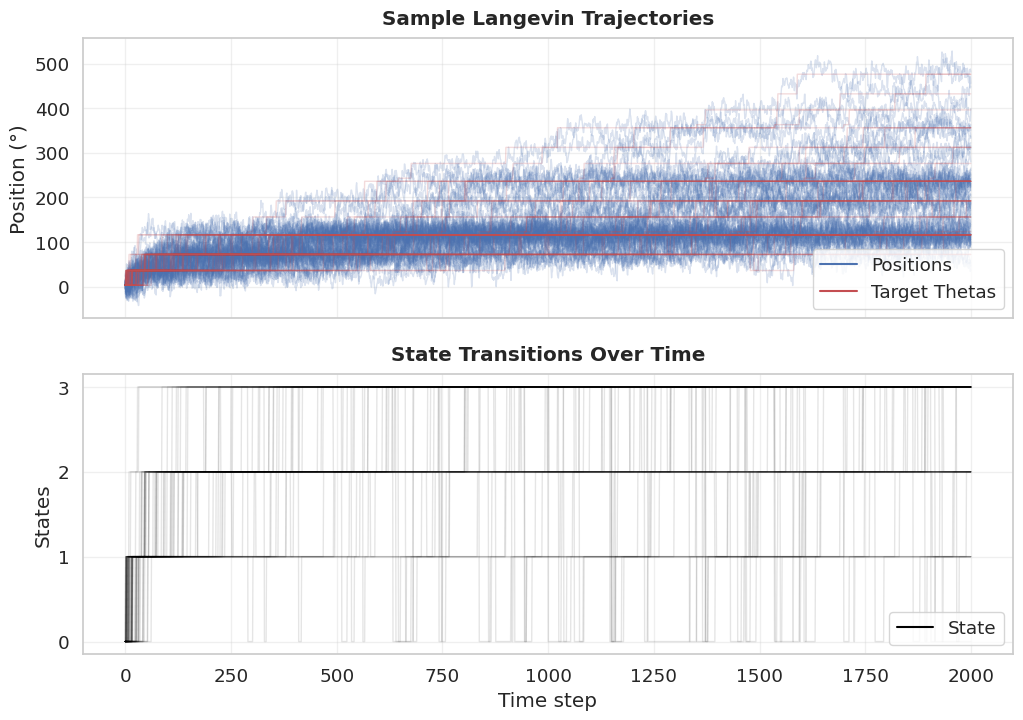

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(combined_bead_positions, color="b", alpha=0.2, linewidth=1)
axs[0].plot([], [], color="b", label="Positions")
axs[0].legend(loc="lower right", frameon=True)
axs[0].plot(np.array(combined_target_thetas), color="r", alpha=0.2, linewidth=1)

axs[0].plot([], [], color="r", label="Target Thetas")
axs[0].set_title("Sample Langevin Trajectories", pad=10, weight="bold")
axs[0].set_ylabel("Position (°)")
axs[0].grid(True, alpha=0.3)
axs[0].legend(loc="lower right", frameon=True)

for state_group in combined_states:
    axs[1].plot(np.array(state_group).T, color="black", alpha=0.1, linewidth=1)

axs[1].set_title("State Transitions Over Time", pad=10, weight="bold")
axs[1].set_xlabel("Time step")
axs[1].set_ylabel("States")
axs[1].grid(True, alpha=0.3)
axs[1].set_yticks(np.arange(len(LG.theta_states)))
axs[1].plot([], [], color="black", label="State")
axs[1].legend(loc="lower right", frameon=True);